In [1]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
import scipy.sparse.csr
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import json
%config InlineBackend.figure_format='retina'

### Список датасетов
 - Gowalla
 - Yelp2018
 - Amazon-book

In [4]:
class Dataset(ABC):
    def __init__(self, ratings_filename, metadata_filename=None):
        self.ratings_filename = ratings_filename
        self.metadata_filename = metadata_filename
        self.df = None

    @staticmethod
    def _parse_json(filename, nrows):
        # pd.read_json('Musical_Instruments_5.json', nrows=10, chunksize=None, lines=True)
        data = []
        with open(filename) as json_file:
            while len(data) < nrows:
                data.append(json.loads(next(json_file)))
        return data

    # @abstractmethod
    def load_dataset(self, nrows):
        pass

    @abstractmethod
    def train_test_split(self):
        pass

    # @abstractmethod
    def cold_start_type_split(self):
        pass

    # @abstractmethod
    def build_sparse_interaction_matrix(self) -> sp.csr_matrix:
        pass

### Метрики

In [2]:
def recall_at_k(pred_items: np.array, true_items: np.array):
    assert pred_items.shape[0] == true_items.shape[0]
    recall_list = []
    for i_pred, i_true in zip(pred_items, true_items):
        try:
            hits = len(np.intersect1d(i_pred, i_true))
            recall = hits / len(i_true)
            recall_list.append(recall)
        except ZeroDivisionError:
            print(len(recall_list), i_true)
    return np.mean(recall_list)

def precision_at_k(pred_items: np.array, true_items: np.array):
    assert pred_items.shape[0] == true_items.shape[0]
    precision_list = []
    for i_pred, i_true in zip(pred_items, true_items):
        try:
            hits = len(np.intersect1d(i_pred, i_true))
            prec = hits / len(i_pred)
            precision_list.append(prec)
        except ZeroDivisionError:
            print(len(precision_list), i_true)
    return np.mean(precision_list)

## Amazon Movies

In [ ]:
class AmazonDataset(Dataset):
    def load_rating_dataset(self, nrows):
        df = pd.read_csv(self.ratings_filename, nrows=nrows, header=None, dtype={3: int})
        df[3] = pd.to_datetime(df[3], unit='s')
        df.columns = ["user", "item", "rating", "timestamp"]
        self.df = df
        return df

    def load_dataset(self, nrows):
        return self._parse_json(self.ratings_filename, nrows)

    def load_metadata(self, nrows):
        return self._parse_json(self.metadata_filename, nrows)

In [8]:
# amazon = AmazonDataset('Musical_Instruments_5.json', 'meta_Appliances.json')
# df = amazon.load_dataset(3)

amazon = AmazonDataset('ratings_Movies_and_TV.csv')
df = amazon.load_rating_dataset(500_000)

In [ ]:
amazon.load_metadata(3)[2]

### Матрица интеракций

In [ ]:
# отфильтруем по позитивным оценкам
df_positive = df[df['rating'] >= 4]
df_positive.shape

In [ ]:
encoder = LabelEncoder()

df_positive.loc[:, 'user'] = encoder.fit_transform(df_positive['user'])
df_positive.loc[:, 'item'] = encoder.fit_transform(df_positive['item'])

In [ ]:
df_positive.nunique()

In [ ]:
# csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
sparse_interactions = sp.csr_matrix((df_positive['rating'], (df_positive['user'], df_positive['item'])))

In [ ]:
sparse_interactions

In [ ]:
sparse_interactions = sp.csr_matrix((df_positive['rating'], (df_positive['user'], df_positive['item'])))

### Собираем граф

In [ ]:
adj_mat = sp.csr_matrix((4, 4)).tolil()
adj_mat[2:, 2:] = [[1, 1], [1, 1]]
adj_mat.todense()

### LGCN-IDE

In [ ]:
class LGCN_IDE(object):
    def __init__(self, adj_mat):
        self.adj_mat = adj_mat

    def train(self, threshold: int):
        adj_mat = self.adj_mat[:threshold]
        rowsum = np.array(adj_mat.sum(axis=1))
        d_inv = np.power(rowsum, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat = sp.diags(d_inv)
        d_mat_i = d_mat
        norm_adj = d_mat.dot(adj_mat)

        colsum = np.array(adj_mat.sum(axis=0))
        d_inv = np.power(colsum, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat = sp.diags(d_inv)
        d_mat_u = d_mat
        d_mat_u_inv = sp.diags(1/d_inv)
        norm_adj = norm_adj.dot(d_mat)
        self.norm_adj = norm_adj.tocsr()

    def getUsersRating(self, batch_users, ds_name):
        norm_adj = self.norm_adj
        batch_test = np.array(norm_adj[batch_users,:].todense())
        U_1 = batch_test @ norm_adj.T @ norm_adj
        if(ds_name == 'gowalla'):
            U_2 = U_1 @ norm_adj.T @ norm_adj
            return U_2
        else:
            return U_1

In [ ]:
y_true = [
    [1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0]
]

y_pred = [
    [2, 3, 0, 0, 0],
    [100, 200, 300, 0, 0]
]

# y_true : ndarray of shape (n_samples, n_labels)
# True targets of multilabel classification, or true scores of entities to be ranked.
#
# y_score: ndarray of shape (n_samples, n_labels)
# Target scores, can either be probability estimates, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).

ndcg_score(y_true, y_pred)

In [ ]:
preds = gf_cf.predict(sparse_interactions)

In [ ]:
%%time
ndcg_score(np.array(preds), np.array(sparse_interactions.todense()))

## MovieLens 100k

In [5]:
class MovieLens(Dataset):
    def load_rating_dataset(self, nrows=None):
        df = pd.read_table(self.ratings_filename,  header=None, nrows=nrows)
        df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        df['user_id'] -= 1
        df['item_id'] -= 1
        self.df = df
        return df

    def train_test_split(self, test_ratio=0.25, observed_ratio=0.5):
        df = self.df
        all_users = self.df['user_id'].unique()
        test_size = int(len(all_users) * test_ratio)

        # Формируем выборку пользователей для теста
        test_users = np.random.choice(a=all_users, size=test_size, replace=False)
        df_train = df[~df['user_id'].isin(test_users)]
        df_test = df[df['user_id'].isin(test_users)]
        df_test = df_test[df_test['item_id'].isin(df_train['item_id'].unique())]

        # Энкодим айдишники айтемов
        encoder = LabelEncoder()
        df_train['user_id'] = encoder.fit_transform(df_train['user_id'])
        df_train['item_id'] = encoder.fit_transform(df_train['item_id'])
        df_test['item_id'] = encoder.transform(df_test['item_id'])

        # Делим интеракции новых пользователей на виденные и будущие
        test_observed, test_future = train_test_split(df_test, test_size=1-observed_ratio, random_state=42)
        test_future = test_future[test_future['user_id'].isin(test_observed['user_id'].unique())]
        test_observed['user_id'] = encoder.fit_transform(test_observed['user_id'])
        test_future['user_id'] = encoder.transform(test_future['user_id'])

        self._df_train = df_train
        self._test_observed = test_observed
        self._test_future = test_future
        self.n_items = df_train['item_id'].nunique()

    def build_sparse_interaction_matrix(self):
        # n_train_users = self.df_train['user_id'].nunique()
        self.train_interactions = sp.csr_matrix((self._df_train['rating'], (self._df_train['user_id'], self._df_train['item_id'])))
        self.observed_interactions = sp.csr_matrix((self._test_observed['rating'],
                                                    (self._test_observed['user_id'], self._test_observed['item_id'])),
                                                   shape=(self._test_observed['user_id'].nunique(), self.n_items)
                                                   )

        self.future_interactions = sp.csr_matrix((self._test_future['rating'],
                                                    (self._test_future['user_id'], self._test_future['item_id'])),
                                                   shape=(self._test_future['user_id'].nunique(), self.n_items)
                                                 )

In [9]:
np.random.seed(42)
mov = MovieLens('ml-100k/u.data')
df = mov.load_rating_dataset()
# df = df[df['rating'] >= 4]
df['rating'] = 1
mov.df = df
df.shape

(100000, 4)

In [10]:
mov.train_test_split(0.3, 0.1)
mov.build_sparse_interaction_matrix()

/var/folders/p_/sddndwcs6m30b1tfj2cy1ys40000gn/T/ipykernel_5438/659572245.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['user_id'] = encoder.fit_transform(df_train['user_id'])
/var/folders/p_/sddndwcs6m30b1tfj2cy1ys40000gn/T/ipykernel_5438/659572245.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['item_id'] = encoder.fit_transform(df_train['item_id'])


In [11]:
mov._df_train['user_id'].nunique()

95

In [12]:
mov.train_interactions

<95x1289 sparse matrix of type '<class 'numpy.int64'>'
	with 10744 stored elements in Compressed Sparse Row format>

In [13]:
mov.observed_interactions

<824x1289 sparse matrix of type '<class 'numpy.int64'>'
	with 8763 stored elements in Compressed Sparse Row format>

In [14]:
mov.future_interactions

<824x1289 sparse matrix of type '<class 'numpy.int64'>'
	with 78247 stored elements in Compressed Sparse Row format>

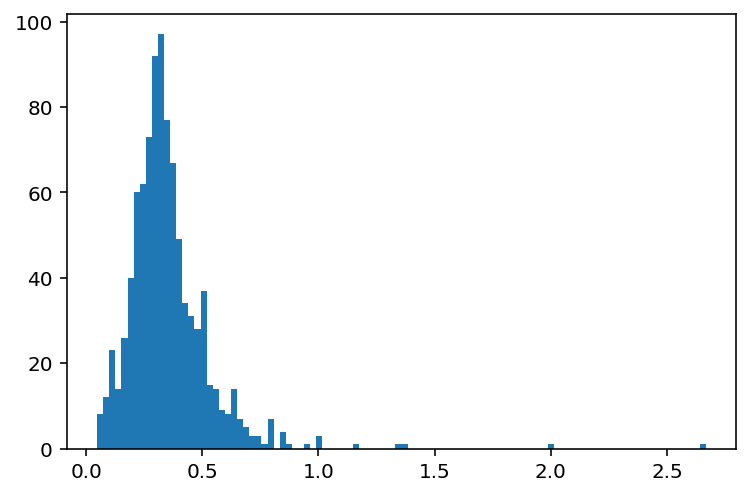

In [218]:
plt.hist(mov.df_test.groupby('user_id')['item_id'].count() / mov.df_train.groupby('user_id')['item_id'].count(), bins=100)
plt.show()

In [207]:
mov.df_train.nunique()

user_id        942
item_id       1395
rating           1
timestamp    26909
dtype: int64

In [208]:
mov.df_test.nunique()

user_id        930
item_id       1160
rating           1
timestamp    11677
dtype: int64

### GF-CF

In [125]:
from sparsesvd import sparsesvd

In [124]:
class GF_CF(object):
    def __init__(self, train_matrix):
        self.train_matrix = train_matrix

    def fit(self, dim=16):
        R = self.train_matrix
        rowsum = np.array(R.sum(axis=1))
        d_inv = np.power(rowsum, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat = sp.diags(d_inv)
        R_norm = d_mat @ R

        colsum = np.array(R.sum(axis=0))
        d_inv = np.power(colsum, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat = sp.diags(d_inv)
        self.d_mat_i = d_mat
        self.d_mat_i_inv = sp.diags(1 / d_inv)
        R_norm = R_norm @ d_mat
        self.R_norm = R_norm.tocsc()
        ut, s, self.vt = sparsesvd(self.R_norm, dim)
        print('Train finished')

    def predict(self, new_ratings: sp.coo_matrix):
        R_norm = self.R_norm
        # new_ratings = new_ratings.todense()
        U_2 = new_ratings @ (R_norm.T @ R_norm)
        U_1 = new_ratings @  (self.d_mat_i @ self.vt.T @ self.vt @ self.d_mat_i_inv)
        predict = U_2 + U_1
        predict[np.isnan(predict)] = 0

        # if ds_name == 'amazon-book':
        #     ret = U_2
        # else:
        #     U_1 = batch_test @  self.d_mat_i @ self.vt.T @ self.vt @ self.d_mat_i_inv
        #     ret = U_2 + 0.3 * U_1
        # return ret
        return predict

    def recommend_top_k(self, interactions: sp.coo_matrix, k=20):
        """
        Предполагается нумерация айтемов с 0, иначе не будет работать argsort
        """
        ranks = self.predict(interactions)
        ranks[interactions.nonzero()] = -1e5  # exclude seen items
        return np.asarray(np.argsort(-ranks, axis=1)[:, :k])

In [61]:
mov.train_test_split(test_ratio=0.3, observed_ratio=0.1)
mov.build_sparse_interaction_matrix()
mov.train_interactions, mov.observed_interactions, mov.future_interactions

/var/folders/p_/sddndwcs6m30b1tfj2cy1ys40000gn/T/ipykernel_5438/659572245.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['user_id'] = encoder.fit_transform(df_train['user_id'])
/var/folders/p_/sddndwcs6m30b1tfj2cy1ys40000gn/T/ipykernel_5438/659572245.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['item_id'] = encoder.fit_transform(df_train['item_id'])


(<661x1641 sparse matrix of type '<class 'numpy.int64'>'
 	with 68377 stored elements in Compressed Sparse Row format>,
 <272x1641 sparse matrix of type '<class 'numpy.int64'>'
 	with 3157 stored elements in Compressed Sparse Row format>,
 <272x1641 sparse matrix of type '<class 'numpy.int64'>'
 	with 28169 stored elements in Compressed Sparse Row format>)

In [145]:
K = 10

gf_cf = GF_CF(mov.train_interactions)
gf_cf.fit(16)
ranks = gf_cf.predict(mov.observed_interactions)
recs = gf_cf.recommend_top_k(mov.observed_interactions, K)

# VALUATION
y_true = np.array([mov.future_interactions[i].nonzero()[1] for i in range(mov.future_interactions.shape[0])], dtype='object')
# print(f'NDGC score = {ndcg_score(np.array(ranks), np.array(mov.future_interactions.todense())).round(5)}')
print('====== GF-CF ======')
print(f'Precision = {precision_at_k(recs, y_true).round(5)}')
print(f'Recall = {recall_at_k(recs, y_true).round(5)}')

Train finished
====== GF-CF ======
Precision = 0.48075
Recall = 0.13219


In [45]:
ranks[mov.observed_interactions.nonzero()] = -1e5

In [239]:
_y_train = np.array([mov.observed_interactions[i].nonzero()[1] for i in range(mov.observed_interactions.shape[0])], dtype='object')
pd.Series(list(map(len, _y_train))).mean()

11.46376811594203

In [232]:
pd.Series(list(map(len, y_true))).mean()

56.02127659574468

### ALS

In [8]:
pd.options.mode.chained_assignment = None

In [13]:
from implicit.als import AlternatingLeastSquares

In [133]:
np.random.seed(42)
mov = MovieLens('ml-100k/u.data')
df = mov.load_rating_dataset()
df = df[df['rating'] >= 4]
df['rating'] = 1
mov.df = df
df.shape

(55375, 4)

In [134]:
mov.train_test_split(test_ratio=0.3, observed_ratio=0.1)
mov.build_sparse_interaction_matrix()

In [135]:
als = AlternatingLeastSquares(16, iterations=10, regularization=0.1, calculate_training_loss=True, random_state=42)
als.fit(mov.train_interactions)

  0%|          | 0/10 [00:00<?, ?it/s]

In [137]:
mov.train_interactions, mov.observed_interactions

(<660x1381 sparse matrix of type '<class 'numpy.int64'>'
 	with 38028 stored elements in Compressed Sparse Row format>,
 <265x1381 sparse matrix of type '<class 'numpy.int64'>'
 	with 1725 stored elements in Compressed Sparse Row format>)

In [138]:
als.partial_fit_users(userids=np.arange(660, 660+265),
                      user_items=mov.observed_interactions)

In [147]:
K = 10
recs = np.array(als.recommend(userid=np.arange(660, 660+265), user_items=mov.observed_interactions, N=K))[0].astype(int)

In [148]:
y_true = np.array([mov.future_interactions[i].nonzero()[1] for i in range(mov.future_interactions.shape[0])],
                   dtype='object')
# pd.Series(list(map(len, y_true))).mean()

In [149]:
print('====== ALS ======')
print(f'Precision = {precision_at_k(recs, y_true).round(5)}')
print(f'Recall = {recall_at_k(recs, y_true).round(5)}')

====== ALS ======
Precision = 0.44
Recall = 0.12397
